### Includes

Import libraries

In [1]:
%matplotlib inline
import sys
import time
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as sc
import numpy as np
import pandas as pd

from statistics import mean, pstdev
from sklearn.linear_model import LinearRegression

mpl.style.use('seaborn-whitegrid')

## Data

Here we define the X and Y data.   
Note the Y-axis represents the 'like' over time, so X-axis represents the time.   
In this example, we represent the absence of the value in `t_3`.

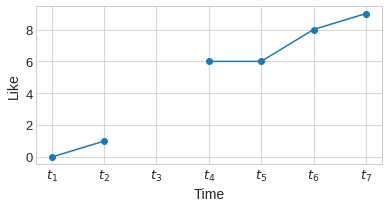

In [2]:
# fictitious data
X = [1, 2, 3,    4, 5, 6, 7]
Y = [0, 1, None, 6, 6, 8, 9]

# Plot define
fontsize = 14
width = 5.5
height = 3

# Plot the fictitious data
fig, axis = plt.subplots()
plt.plot(X, Y, marker='o')
plt.ylabel('Like', fontsize=fontsize)
plt.xlabel('Time', fontsize=fontsize)
plt.xticks(X, [r'$t_{i}$'.format(i=i) for i in X])
plt.tick_params(axis='both', which='major', labelsize=fontsize-1)
fig.set_size_inches(width, height)
plt.tight_layout()
plt.show()

## Feature Extractors

1. Linear Regression (LR)
2. Delta Rank (DR)
3. Coefficient of Angle (CA)

### 1. Linear Regression (LR) Extractor

In [3]:
# ------------------------------------------------
# Simple Linear Regression Model
# ------------------------------------------------
class LeastSquares:
    # Init the model
    def __init__(self):
        self._model = None
    
    
    # Least Squares
    #- X: X-axis values
    #- Y: Y-axis values
    #- return: None
    def compute(self, X, Y):
        alpha, beta = 0, 0
        ran = range(len(X))
        beta = sum([X[i]*Y[i] for i in ran]) - 1/len(X)*sum(X)*sum(Y)
        beta = beta / (sum([X[i]*X[i] for i in ran]) - 1/len(X)*(sum(X)**2))
        alpha = mean(Y) - beta*mean(X)
        self._model = (alpha, beta)
    
    
    # Prediction
    #- x: x value
    #- return: predicted y value
    def predict(self, x):
        alpha, beta = self._model
        pred = alpha + beta*x
        return pred
    
    
    # Get Model
    #- return: the model (alpha, beta)
    def get_model(self):
        alpha, beta = self._model
        return (alpha, beta)

In [4]:
# ------------------------------------------------
# Linear Regression (LR) Extractor
# ------------------------------------------------
class LR_Extractor:

    # Init the model
    def __init__(self):
        self._model = LeastSquares()
    
    
    # Extraction
    #- X: X-axis values
    #- Y: Y-axis values
    #- return: model (LeastSquares),
    #          R2, Angle (degrees)
    def compute(self, X, Y):
        X, Y = self._clean(X, Y)
        # Least Squares
        reg = LinearRegression().fit([[i] for i in X], Y)
        self._model.compute(X, Y)
        r2 = reg.score([[i] for i in X], Y)
        # Angle in degrees
        x = [X[0], X[len(X)-1]]
        y = list(map(lambda a: reg.predict([[a]])[0], x))
        radians = math.atan2(y[1]-y[0], x[1]-x[0])
        degrees = math.degrees(radians)
        # return
        return self._model, r2, degrees
    
    
    # Clean - remove None
    #- X: X-axis values
    #- Y: Y-axis values
    #- return: X, Y
    def _clean(self, X, Y):
        x, y = [], []
        for i in range(len(Y)):
            if(Y[i] is not None):
                x.append(X[i])
                y.append(Y[i])
        return x, y

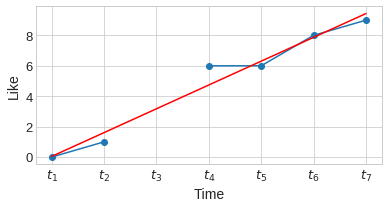

- LR Extractor example
model: (-1.5217391304347831, 1.565217391304348)
R2   : 0.9668
angle: 57.43o


In [5]:
# LR Extractor
extractor = LR_Extractor()
model, r2, degrees = extractor.compute(X, Y)
line = [X[0], X[-1]]

# Plot
fig, axis = plt.subplots()
plt.plot(X, Y, marker='o')
plt.plot(line, [model.predict(x) for x in line], color='r')
plt.ylabel('Like', fontsize=fontsize)
plt.xlabel('Time', fontsize=fontsize)
plt.xticks(X, [r'$t_{i}$'.format(i=i) for i in X])
plt.tick_params(axis='both', which='major', labelsize=fontsize-1)
fig.set_size_inches(width, height)
plt.tight_layout()
plt.show()

# Print
print('- LR Extractor example')
print('model: {!r}'.format(model.get_model()))
print('R2   : {:.4f}'.format(r2))
print('angle: {:.2f}o'.format(degrees))

### Delta Rank (DR) Extractor

In [6]:
# ------------------------------------------------
# Delta Rank (DR) Extractor
# ------------------------------------------------
class DR_Extractor:

    # Init the model
    def __init__(self):
        self._D = None

    # Extraction
    #- X: X-axis values
    #- Y: Y-axis values
    #- return: D, entropy(D)
    def compute(self, X, Y):
        idx, last = 0, len(Y)-1
        self._D = []
        while idx < last:
            # exist keys? (in range)
            nxt = idx + 1
            if Y[nxt] is not None and Y[idx] is not None in Y:
                delta = Y[nxt] - Y[idx]
                self._D.append(delta)
            idx += 1
        return self._D, self._entropy(self._D)

    # Entropy
    #- values: list of values
    def _entropy(self, values):
        serie = pd.Series(values)
        p_data = serie.value_counts() / len(serie)  # calculates the probabilities
        score = sc.stats.entropy(p_data)  # input probabilities to get the entropy
        return score

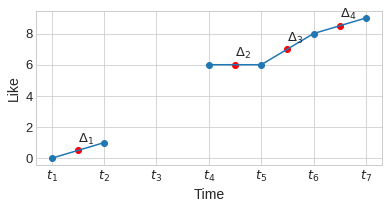

- DR Extractor example
Deltas: [1, 0, 2, 1]
entropy(D): 1.0397207708399179


In [7]:
# DR Extractor
extractor = DR_Extractor()
D, S_D = extractor.compute(X, Y)

# Plot
fig, axis = plt.subplots()
plt.plot(X, Y, marker='o')

idx, last = 0, len(Y)-1
i = 1
while idx < last:
    nxt = idx + 1
    if Y[nxt] is not None and Y[idx] is not None in Y:
        x = X[idx]+(X[nxt]-X[idx])/2.0
        y = Y[idx]+(Y[nxt]-Y[idx])/2.0
        plt.scatter(x, y, color='r')
        axis.text(x, y+0.5, r'$\Delta_{i}$'.format(i=i), fontsize=fontsize-1)
        i += 1
    idx += 1

plt.ylabel('Like', fontsize=fontsize)
plt.xlabel('Time', fontsize=fontsize)
plt.xticks(X, [r'$t_{i}$'.format(i=i) for i in X])
plt.tick_params(axis='both', which='major', labelsize=fontsize-1)
fig.set_size_inches(width, height)
plt.tight_layout()
plt.show()

# Print
print('- DR Extractor example')
print('Deltas:', D)
print('entropy(D):', S_D)

### Coefficient of Angle (CA) Extractor

In [8]:
# ------------------------------------------------
# Coefficient of Angle (CA) Extractor
# ------------------------------------------------
class CA_Extractor:

    # Init the model
    def __init__(self):
        self._T = None

    # Extraction
    #- X: X-axis values
    #- Y: Y-axis values
    #- return: T
    def compute(self, X, Y):
        idx, last = 0, len(Y)-1
        self._T = []
        while idx < last:
            # exist keys? (in range)
            nxt = idx + 1
            if Y[nxt] is not None and Y[idx] is not None in Y:
                delta = Y[nxt] - Y[idx]
                radians = math.atan2(delta, 1)
                degrees = math.degrees(radians)
                self._T.append(degrees)
            idx += 1
        return self._T

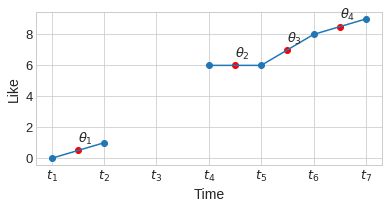

- CA Extractor example
Theta: [45.0, 0.0, 63.43494882292201, 45.0]


In [9]:
# CA Extractor
extractor = CA_Extractor()
T = extractor.compute(X, Y)

# Plot
fig, axis = plt.subplots()
plt.plot(X, Y, marker='o')

idx, last = 0, len(Y)-1
i = 1
while idx < last:
    nxt = idx + 1
    if Y[nxt] is not None and Y[idx] is not None in Y:
        x = X[idx]+(X[nxt]-X[idx])/2.0
        y = Y[idx]+(Y[nxt]-Y[idx])/2.0
        plt.scatter(x, y, color='r')
        axis.text(x, y+0.5, r'$\theta_{i}$'.format(i=i), fontsize=fontsize-1)
        i += 1
    idx += 1

plt.ylabel('Like', fontsize=fontsize)
plt.xlabel('Time', fontsize=fontsize)
plt.xticks(X, [r'$t_{i}$'.format(i=i) for i in X])
plt.tick_params(axis='both', which='major', labelsize=fontsize-1)
fig.set_size_inches(width, height)
plt.tight_layout()
plt.show()

# Print
print('- CA Extractor example')
print('Theta:', T)